# Part I: Conformal Regression

We consider a simple regression problem on heteroskedastic data. We want to evaluate the uncertainty associated with the prediction using various conformal prediction methods. The main objective of this first part is to get a better grasp of how Conformal Prediction works, and to *visualize* the effect of the different algorithms on the coverage rate and the size of the prediction intervals. We will code most of the algorithms from scratch, and compare our results with those obtained with help of the PUNCC library for verification purposes.

**Links**
- [PUNCC Github](https://github.com/deel-ai/puncc)
- [PUNCC Documentation](https://deel-ai.github.io/puncc/index.html)

## 0. Setup

**Exercise.** Install the puncc library using pip

In [1]:
# TODO: install the PUNCC library
!pip install puncc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.8/70.8 kB 2.8 MB/s eta 0:00:00


We import some of the libraries that we will be using throughout.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

## 1. Dataset

We consider a synthetic 1D heteroskedastic dataset, where the variance of the noise increases with the value of the input feature.
We generate $N$ samples as follows:

- Inputs $X$ are uniformly distributed on $[0, 20]$
- Outputs are given by $Y = (1+\epsilon)\cdot X, $

Such that $\epsilon \sim {\cal N}(\mu=0,\sigma=1)$ is standard gaussian noise.

**Exercise.**
1. Complete the function `heteroskedastic_data` that takes the number of samples `n_samples` to be generated as an arguments, and outputs numpy arrays `X` and `y` of size `n_samples` according to the procedure described above.
2. Use the `heteroskedastic_data` function to generate 4000 samples.

In [19]:
# Generate synthetic 1D heteroskedastic data

def heteroskedastic_data(n_samples):
    # TODO: complete
    X=np.random.uniform(0,20,n_samples)
    Y=(1+np.random.normal(0,1,n_samples)) * X
    X = X.reshape(-1, 1)
    return X,Y


# TODO: generate 4000 samples
n_samples = 4_000
X, Y = heteroskedastic_data(n_samples)

**Exercise.** Complete the function `plot_data below`, and use it to plot the synthetic data.

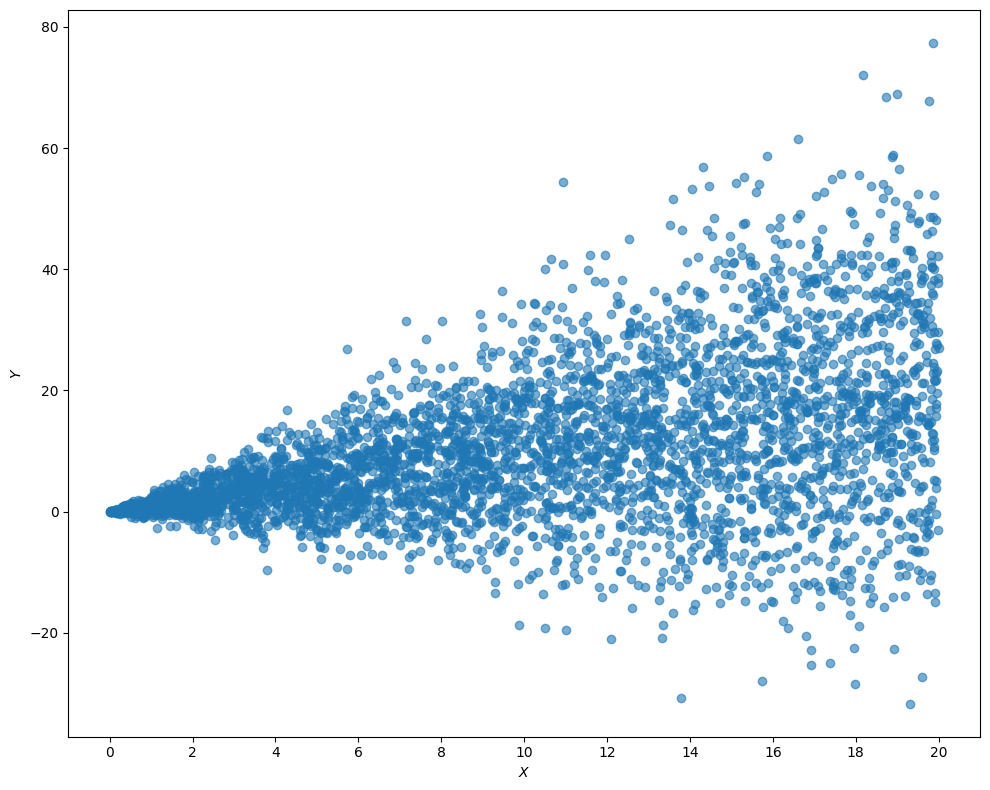

In [20]:
def plot_data(X, y):
    plt.figure(figsize=(10, 8))
    # TODO: plot the data, what plot type would you choose?
    plt.scatter(X,y, alpha=0.6)
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    plt.xticks(np.arange(22, step=2))
    plt.tight_layout()
    plt.grid(False)
    plt.show()

# TODO: plot the data
plot_data(X,Y)

**Exercise.** Split the data into a training set and a test set by using the `train_test_split` function of the `scikit-learn` library. Split the data randomly and leaving out 25% of the data for the test set.

In [21]:
# TODO: Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

## 2. Split Conformal Regression

In order to perform the *split conformal regression* algorithm, we need to split our training data into a *proper training set* (which we will store in the variables `X_fit` and `y_fit`) and a *calibration set*.

**Exercise.** Further split the training data randomly by leaving out 50% of the training data for the calibration set.

In [22]:
# TODO: Split the data

X_fit, X_calib, Y_fit, Y_calib = train_test_split(X_train, Y_train, test_size=0.5)

**Exercise.** Train a prediction model using the `LinearRegression` class in the `scikit-learn` library.

In [23]:
# TODO: Train the model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_fit, Y_fit)

LinearRegression()

**Exercise.** Complete the `plot_model` function below in order to plot synthetic data along with the model predictions. Use the function `plot_model` to plot the test data along with the model predictions.

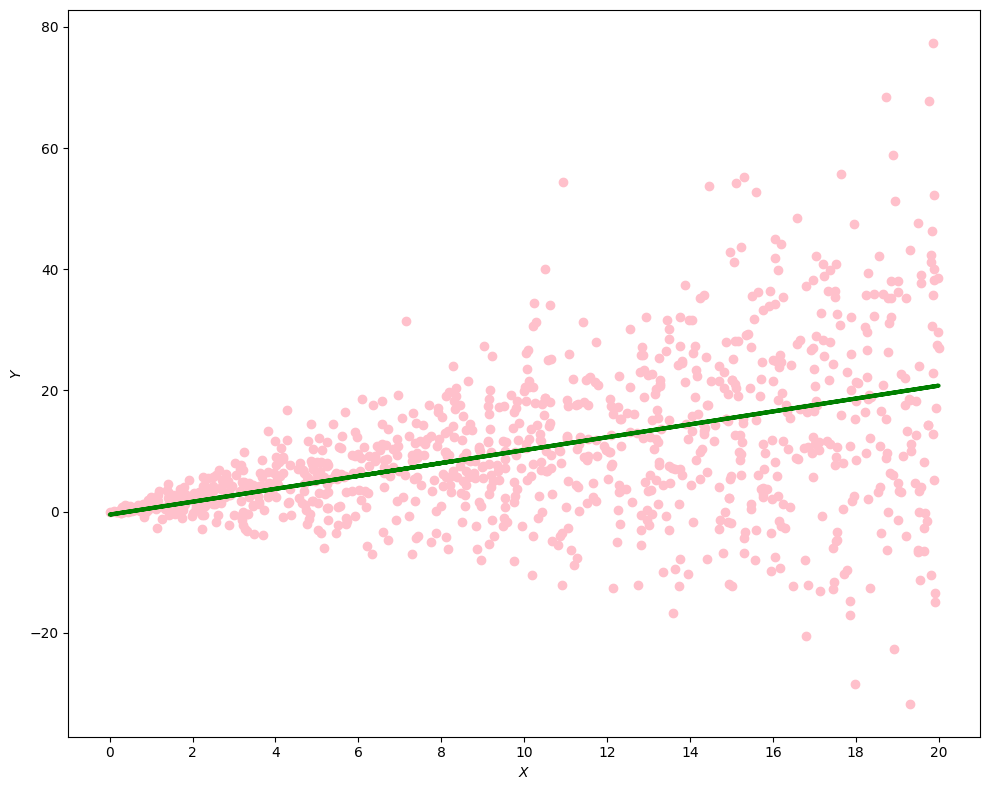

In [39]:
def plot_model(model, X, y):
    plt.figure(figsize=(10, 8))
    # TODO: plot the data
    plt.scatter(X,y, color='pink')
    # TODO: plot the model predictions
    plt.plot(X,model.predict(X), color='green', linewidth=3)
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    plt.xticks(np.arange(22, step=2))
    plt.tight_layout()
    plt.grid(False)
    plt.show()

# TODO: visualize the data and model in the same plot
plot_model(model, X_test, Y_test)

Now that we have a trained model, we wish to *conformalize* it. The simplest algorithm to conformalize a model is the *split conformal* algorithm.

In this section, we are using the split conformal algorithm for the regression task, but as we have seen in the lectures, there are many other algorithms conformalization algorithms that rely on splitting the data into fit and calibration setl. Therefore, we will coda a generc class called `SplitConformal` that we will be able to use later for other conformal prediction algorithms of the *split* type.

In order to define our general `SplitConformal` class, we will rely on the following information:
the algorithms using the `SplitConformal` class are different between each other only in two ways:
- the way the *nonconformity scores* are computed,
- the way the *prediction sets* are constructed.

Therefore, we will build the `SplitConformal` class so that it can work with any choice of *nonconformity score function* a *prediction set contruction function*.


**Exercise.** Code the `SplitConformal` class by implementing the following:
1. Attributes:
  - `score_fn`: the nonconformity score function to be used (a function that computes scores between ground truth values and model predictions).
  - `predset_fn`: the prediction set construction function to be used (a function that builds prediction sets from model predictions and quantile values).
  - `scores`: attribute to store the array of calibration nonconformity scores.
  - `quantile`: attribute to store the value of the quantile of order $1-\alpha$ (plus correction).

2. Methods:
  - `__init__`: takes as input the choice of nonconformity score function and prediction set construction function.
  - `compute_scores`: takes as input a numpy array containing ground truth $y$-values and predicted $y$-values, computes the nonconformity scores, and stores them into the attribute `scores`.
  - `compute_quantile`: takes as input the nominal error rate $\alpha$ and computes the quantile of level $1-\alpha$ (taking into account the usual finite-sample correction characteristic of conformal prediction algorithms) on the array of scores saved in the `scores` attribute. **Warning!** You may use the `quantile` function in the `numpy` library, however, make sure you choose the *right* method to compute the quantile values, otherwise the probabilistic guarantee of conformal prediction will no longer be true. (**This is an important point, try and understand the different methods and choose the correct one yourself before checking the solutions!!!**)
  - `predict`: takes as input an array of model predictions and outputs prediction sets (in whatever format the `predset_fn` outputs prediction sets).

In [40]:
class SplitConformal():
    # TODO: Complete the class
    def __init__(self, score_fn, predset_fn):
        self.score_fn = score_fn
        self.predset_fn = predset_fn
        self.scores = None
        self.quantile = None

    def compute_scores(self, y_true, y_pred):
        self.scores = self.score_fn(y_true, y_pred)

    def compute_quantile(self, alpha):
        #self.quantile = np.quantile(self.scores, 1-alpha)
        corrected_alpha = np.ceil((1 - alpha) * (len(self.scores) + 1)) / len(self.scores)
        self.quantile = np.quantile(self.scores, corrected_alpha, method="inverted_cdf")

    def predict(self, y_pred):
        return self.predset_fn(y_pred, self.quantile)

**Exercise.** Code the `abs_difference` and `additive_interval` functions to be used as the arguments of the `SplitConformal` class at initialization.

In [42]:
# TODO: code both functions
def abs_difference(y_true, y_pred):
    return np.abs(y_true - y_pred)

def additive_interval(y_pred, quantile):
    return y_pred - quantile , y_pred + quantile

**Exercise.** Use the `SplitConformal` class to conformalize the Linear Regression model with a nominal error rate of 0.1.

In [43]:
# TODO: conformalize
alpha = 0.1

y_pred_calib = model.predict(X_calib)
splitcr = SplitConformal(abs_difference, additive_interval)
splitcr.compute_scores(Y_calib, y_pred_calib)
splitcr.compute_quantile(alpha)

y_pred_test = model.predict(X_test)
y_lower, y_upper = splitcr.predict(y_pred_test)

**Exercise.** Complete the function `plot_conformalized_data` below and use it to plot the test datset along with the model predictions and the prediction intervals.

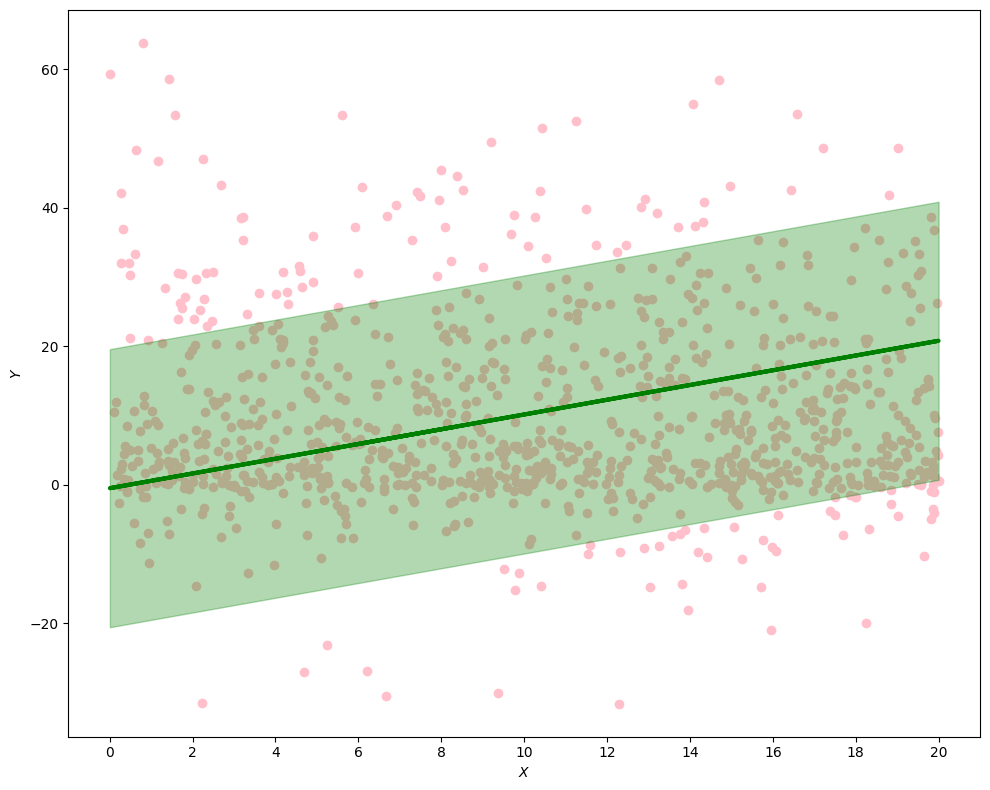

In [44]:
def plot_conformalized_data(X, y, y_pred, y_lower, y_upper):
    plt.figure(figsize=(10, 8))
    sort_indices = np.argsort(X.flatten())

    # TODO: plot the data
    plt.scatter(X,y, color='pink')
    # TODO: plot the model predictions
    plt.plot(X, y_pred, color="green", linewidth=3)
    # TODO: plot the prediction interval
    plt.fill_between(
        X[sort_indices].flatten(),
        y_lower[sort_indices],
        y_upper[sort_indices],
        alpha=0.3,
        color="green",
    )
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    plt.xticks(np.arange(22, step=2))
    plt.tight_layout()
    plt.grid(False)
    plt.show()

plot_conformalized_data(X_test, y_test, y_pred_test, y_lower, y_upper)

**Exercise.** Write a function called `evaluate_conformal_regression` that takes as input an array of ground-truth $y$-values along with an array of the lower limits and an array of the upper limits of the corresponding prediction intervals. It then computes and outputs the following two metrics:
1. `coverage`: The average number of intervals that contain the ground-truth values.
2. `avg_length`: The average length of the intervals.

**Questions.**
1. What value should we expect for the `coverage` metric?
2. What kind of values do we desire for the `avg_length` metric?


In [ ]:
# TODO: implement the evaluate_conformal_regression function

**Exercise.** Evaluate the conformalized model with the help of the `evaluate_conformal_regression` function and display the results.

In [ ]:
# TODO: evaluate the conformal prediction regressor

The evaluation seems to match the desired results. Note however (from the plot) how the interval length is constant, and does not match the heteroskedasticity of the data.

Next, we perform a similar conformalization procedure using the PUNCC library, this will allow us to compare results, but also to learn how the PUNCC library works so that we can use it in the future instead of coding the CP algorithms from scratch.

**Exercise.** Find the tutorial called *Introduction Tutorial* in the Readme page of the PUNCC github repository and dollow the steps presented in the *Conformal Regression* section in order to conformalize the linar regression model above using PUNCC:
1. Train the model using PUNCC rather than fitting it directly.
2. Compute the prediciton intervals.
3. Compute the evaluation metrics.
4. Use PUNCC's visualization tools to visualize the results.

## 3. Cross-Validation+ (CV+)
As seen during the lecture, practitionners are not always willing to sacrifice part of the training data for the calibration phase. Of course, this is not a problem for our toy case, where we can generate as many extra exmaple as we wish... but we will nevertheless implemnt
the *Cross-Validation+* algorithm, which allows to use the whole training dataset for training, instead of splitting it into a proper training set and a calibration set. Of course, this comes at the cost of having to train multiple models.

**Exercise.** Use the `KFold` class from `scikit-learn` to:
1. Train 10 different linear regression models according to the CV+ algorithm.
2. Compute the nonconformity scores on each of the folds.

Store the models into a list of models called `models` and the scores in a numpy array called `scores`.

**Warning.** Read carefully the documentaion of the `Kfold` function, we will be using it again further down to compute the prediction sets and the point predictions on the test sets, and we need to make sure that the data is split in the exact same folds both times!

In [ ]:
# TODO: train and compute scores according to the CV+ algorithm

**Exercise.** Use the CV+ algorithm to produce prediction intervals for nominal $\alpha=0.1$. Compute point predictions on the test set by averaging accross the 10 different models.

In [ ]:
# TODO: Conformalize the model using the CV+ algorithm

**Exercise.** Evaluate and plot the results.

In [ ]:
# TODO: Evaluate the results

# TODO: plot the conformalized data

**Exercise.** Perform the Cross-Validation using PUNCC and compare the result, there is no tutorial for this algorithm, but you can check the following section in the documentation to help yourself:

https://deel-ai.github.io/puncc/regression.html#deel.puncc.regression.CVPlus

Note that whereas the guarantee provided by the CV+ method is
$$\mathbb{P}(Y_{n+1}\in \hat{C}_\alpha(X_{n+1})) \geq 1-2\alpha,$$
however the achieved coverage rate is rather close to $1-\alpha$.

**Question.** How can you explain this?

## 4. Conformal Quantile Regression
We now turn to the problem of the *constant* prediction intervals. As we can see in the plots above, the coverage rate of $1-\alpha$ is obtained by over-covering in the low-variance regions and over-covering in the high variance regions. We next consider the *Conformalized Quantile Regression (CQR)* algorithm, the purpose of which is to generate prediction sets that are more adapted to the heteroskedasticity of the data. CQR extends traditional quantile regression by incorporating conformal prediction techniques, allowing us to construct predictive intervals with state-of-the-art performance and guaranteed coverage (under data exchangeability).

**Exercise.** Train lower and upper quantile models for a nominal eror rate $\alpha$ of 0.1, using the `GradientBoostingRegressor` model with 10 estimators from the `sklearn.ensemble` module.

**Careful!** The CQR algorithm is a kind of *split conformal* algorithm, so we neet to use the *fit* data split to train the models, and hold out the *calibration* data split for the calibration phase.

In [ ]:
# TODO: train the lower and upper quantile models

**Exercise.** Complete the `plot_quantile_model` function below and use it to plot the test examples along with the lower and upper quantile model predictions.

In [ ]:
def plot_quantile_models(X, y, lower_quantile_model, upper_quantile_model):
    plt.figure(figsize=(10, 8))
    sort_indices = np.argsort(X.flatten())
    X_sorted = X[sort_indices]
    y_sorted = y[sort_indices]
    # TODO: plot the data
    # TODO: plot the lower quantile predictions
    # TODO: plot the upper quantile predictions
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    plt.xticks(np.arange(22, step=2))
    plt.tight_layout()
    plt.grid(False)
    plt.show()


plot_quantile_models(X_test, y_test, lower_quantile_model, upper_quantile_model)

**Exercise.** Code the functions `cqr_score` and `cqr_set` so that we can use them along with the class `SplitConformal` above in order to implement the CQR algorithm. In order to keep a structure compatible with the `SplitConformal` class above, the `y_pred` input to the `cqr_score` and `cqr_set` functions is an array of length 2, where the first element contains the predictions of the lower quantile model and the second one the predictions of the upper quantile model.

**Careful!** There is a typo in the lecture notes!

In [ ]:
# TODO: implement the functions

**Exercise.** Conformalize the quantile regressors using the CQR algorithm and the calibration dataset.

In [ ]:
# TODO: Conformalize according to the CQR algorithm

**Exercise.** Evaluate and visualize the results of the CQR conformalized model-

In [ ]:
# TODO: evaluate the results

def plot_cqr_conformalized_data(X, y, y_pred_lower, y_pred_upper, y_lower, y_upper):
    plt.figure(figsize=(10, 8))
    sort_indices = np.argsort(X.flatten())
    X_sorted = X[sort_indices]
    y_pred_lower_sorted = y_pred_lower[sort_indices]
    y_pred_upper_sorted = y_pred_upper[sort_indices]
    y_lower_sorted = y_lower[sort_indices]
    y_upper_sorted = y_upper[sort_indices]

    plt.scatter(X, y, alpha=0.6)
    plt.plot(X_sorted, y_pred_lower_sorted, color="red", linewidth=3)
    plt.plot(X_sorted, y_pred_upper_sorted, color="red", linewidth=3)
    plt.fill_between(
        X_sorted.flatten(),
        y_lower_sorted,
        y_upper_sorted,
        alpha=0.3,
        color="green",
    )
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    plt.xticks(np.arange(22, step=2))
    plt.tight_layout()
    plt.grid(False)
    plt.show()

plot_cqr_conformalized_data(X_test, y_test, y_pred_test_lower, y_pred_test_upper, y_lower, y_upper)

**Questions.**
- What do you observe?
- Is this the expected behavior? Why?
- How does the average interval width compare with the previous methods?

**Exercise.** Implement the CQR algorithm in with PUNCC and compare the results with the ones obtained above.

# Part II: Conformal Classification

The objective of this section is to train a small neural network on the MNIST dataset and apply the Conformal Classification algorithms seen during the lecture.

 ## 1. Dataset
**Exercise.**
1. Import the MNIST dataset from keras.
2. Split the training set into a proper training set, which we call the `fit` dataset, and a calibration set. Use the first 50_000 training points for the fit dataset and the remaining ones for the calibration dataset.
3. Convert the labels to categorical, and save them into new arrays.

In [ ]:
# TODO: Import and pre-process the data according to the instructions.

## 2. Model

**Exercise.** Define a simple convolutional neural network having the following sequential architecture:
- A convolution with kernel size 3 and 16 channels.
- A ReLU activation.
- A max pooling layer with kernel size 2.
- A convolution with kernel size 3 and 32 channels.
- A reLU activation.
- A max pooling layer with kernel size 2.
- A Fully connected layer with 10 neurons.
- A softmax activation.

**Warning!** Use tensorflow, it is easier to use with PUNCC later.

In [ ]:
from tensorflow import random
from tensorflow import keras
from tensorflow.keras import layers

random.set_seed(0)
keras.utils.set_random_seed(0)

# Classification model: convnet composed of two convolution/pooling layers
# and a dense output layer
nn_model = ...  # TODO: define the network

## 3. Training

**Exercise.** Train the model using the Adam optimizer, and the categorical cross-entropy loss. Plot the training and validation accuracy while training, with 10% of the fit data left out for the validation set.

Train the model for 2 epochs with a batch size of 256.

In [ ]:
# TODO: Train the model for two epochs

## 4. Least Ambiguous Set-Valued Classifiers (LAC)
We now implement the LAC algorithm seen during the lecture.

**Exercise.** Define a `lac_score` and a `lac_set` function in order to be used with the `SplitConformal` class above.

In [ ]:
# TODO: define both functions

**Exercise.** Conformalize the classification model.

In [ ]:
y_pred_calib = nn_model.predict(X_calib)
y_pred_test = nn_model.predict(X_test)

In [ ]:
# TODO: Conformalize the classifier using the calibration dataset and a nominal error rate of 0.1

**Exercise.** Evaluate the results by computing the average coverage and average size of the prediction sets on the test set.

In [ ]:
def eval_conformal_classifier(y_true, y_predset):
    # TODO: implement the function to compute both metrics (coverage and set size)

# TODO: Evaluate the conformalized model.

**Exercise.** Plot a random image along with the prediction set.

In [ ]:
sample = 18

plt.imshow(X_test[sample].reshape((28,28)))
_ = plt.title(f"Point prediction: {np.argmax(y_pred[sample])} \n Prediction set: {y_predset_test[sample]}")
_ = plt.xticks([])
_ = plt.yticks([])

**Questions.**
1. How come the average size of the prediction sets is smaller than 1 ?
2. Some of the prediction sets are empty, they contain no labels. Why? Do you think that this is an Ok behavior?

## 5. Regularized Adaptive Prediction Sets
**Exercise.** Follow the *Introduction Tutorial* in PUNCC, the section on *Conformal Classification* to implement the RAPS method as in the tutorial. Compare the results thus obtained with those obtained from the LAC method.

# To go further

1. Code the APS and RAPS algorithms from scratch without using PUNCC.
2. Check out the MAPIE library, which is a nice alternative to PUNCC.
3. Check out the algorithms for Conformal Anomaly Detection and Conformal Object Detection in PUNCC.